#drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#geodesc.git

#contextdesc

## 環境構築

In [ ]:
!pip uninstall -y tensorflow-gpu
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
!pip install tensorflow==1.14.0
!pip uninstall  -y opencv-contrib-python
!pip uninstall -y  opencv-python
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
!pip install open3d-python
# !rm -rf /usr/local/lib/python3.6/dist-packages/cv2

## ソースダウンロード

In [5]:
bp='/content/drive/MyDrive/00_work/004_pose_estimation/'

In [6]:
%cd {bp}

/content/drive/MyDrive/00_work/004_pose_estimation


In [3]:
# !git clone https://github.com/lzx551402/contextdesc.git

##訓練済みモデルダウンロード

In [4]:
# !mkdir {bp}/contextdesc/pretrained
# %cd {bp}/contextdesc/pretrained
# !wget https://research.altizure.com/data/contextdesc_models/contextdesc_pp.tar
# !tar -xvf contextdesc_pp.tar
# !wget https://research.altizure.com/data/contextdesc_models/retrieval_model.tar
# !tar -xvf retrieval_model.tar
# !wget https://research.altizure.com/data/contextdesc_models/dense-contextdesc.tar
# !tar -xvf dense-contextdesc.tar

In [7]:
%cd {bp}/contextdesc
# !python image_matching.py 
  # --loc_model '/content/contextdesc/pretrained/dense-contextdesc'
# --reg_model 'pretrained/contextdesc++'

/content/drive/MyDrive/00_work/004_pose_estimation/contextdesc


## 特徴取得

In [ ]:
#!/usr/bin/env python3
import sys
%cd {bp}/contextdesc
LOCAL_PATH = '../'
if LOCAL_PATH not in sys.path:
    sys.path.append(LOCAL_PATH)
import os
from models import get_model
from models.reg_model import RegModel
UTILS_PATH="{bp}/contextdesc/"
if UTILS_PATH not in sys.path:
    sys.path.append(UTILS_PATH)
os.environ['PYTHONPATH'] = '/env/python:{bp}/contextdesc/'
# get_model('reg_model')
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

UTILS_PATH = 'utils'
if UTILS_PATH not in sys.path:
    sys.path.append(UTILS_PATH)
from opencvhelper import MatcherWrapper

from easydict import EasyDict

UTILS_PATH = '../models'
if UTILS_PATH not in sys.path:
    sys.path.append(UTILS_PATH)
from models import get_model



FLAGS = EasyDict({})
FLAGS.loc_model='pretrained/contextdesc++'
FLAGS.reg_model='pretrained/retrieval_model'
FLAGS.img1_path='imgs/rgb_cam0.png'
FLAGS.img2_path='imgs/rgb_cam1.png'
FLAGS.n_sample=2048
FLAGS.model_type='pb'
FLAGS.dense_desc=False
FLAGS.ratio_test=False
FLAGS.cross_check=False


def load_imgs(img_paths):
    rgb_list = []
    gray_list = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
        img = img[..., ::-1]
        rgb_list.append(img)
        gray_list.append(gray)
    return rgb_list, gray_list


def extract_regional_features(rgb_list, model_path):
    reg_feat_list = []
    model = get_model('reg_model')(model_path)
    for _, val in enumerate(rgb_list):
        reg_feat = model.run_test_data(val)
        reg_feat_list.append(reg_feat)
    model.close()
    return reg_feat_list


def extract_local_features(gray_list, model_path):
    cv_kpts_list = []
    loc_info_list = []
    loc_feat_list = []
    sift_feat_list = []
    model = get_model('loc_model')(model_path, **{'sift_desc': True,
                                                  'n_sample': FLAGS.n_sample,
                                                  'peak_thld': 0.04,
                                                  'dense_desc': FLAGS.dense_desc,
                                                  'upright': False})
    for _, val in enumerate(gray_list):
        loc_feat, kpt_mb, normalized_xy, cv_kpts, sift_desc = model.run_test_data(val)
        raw_kpts = [np.array((i.pt[0], i.pt[1], i.size, i.angle, i.response)) for i in cv_kpts]
        raw_kpts = np.stack(raw_kpts, axis=0)
        loc_info = np.concatenate((raw_kpts, normalized_xy, loc_feat, kpt_mb), axis=-1)
        cv_kpts_list.append(cv_kpts)
        loc_info_list.append(loc_info)
        sift_feat_list.append(sift_desc)
        loc_feat_list.append(loc_feat / np.linalg.norm(loc_feat, axis=-1, keepdims=True))
    model.close()
    return cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list


def extract_augmented_features(reg_feat_list, loc_info_list, model_path):
    aug_feat_list = []
    model = get_model('aug_model')(model_path, **{'quantz': False})
    assert len(reg_feat_list) == len(loc_info_list)
    for idx, _ in enumerate(reg_feat_list):
        aug_feat, _ = model.run_test_data([reg_feat_list[idx], loc_info_list[idx]])
        aug_feat_list.append(aug_feat)
    model.close()
    return aug_feat_list

In [25]:
cam_zed2_22378008_left_hd1080 = EasyDict({})
cam_zed2_22378008_left_hd1080.fx=1055.26
cam_zed2_22378008_left_hd1080.fy=1054.92
cam_zed2_22378008_left_hd1080.cx=962.91
cam_zed2_22378008_left_hd1080.cy=567.182
cam_zed2_22378008_left_hd1080.depthScale=1000.0

'''

      "fx": 1058.51,
      "fy": 1057.56,
      "cx": 972.89,
      "cy": 570.658,
'''
cam_zed2_21888201_left_hd1080 = EasyDict({})
cam_zed2_21888201_left_hd1080.fx=1058.51
cam_zed2_21888201_left_hd1080.fy=1057.56
cam_zed2_21888201_left_hd1080.cx=972.89
cam_zed2_21888201_left_hd1080.cy=570.658
cam_zed2_21888201_left_hd1080.depthScale=1000.0

'''

   "StereoLabs_ZED2_22115402_LEFT_HD1080": {
      "fx": 1058.82,
      "fy": 1058.16,
      "cx": 909.73,
      "cy": 560.099,
'''
cam_zed2_22115402_left_hd1080 = EasyDict({})
cam_zed2_22115402_left_hd1080.fx=1058.82
cam_zed2_22115402_left_hd1080.fy=1058.16
cam_zed2_22115402_left_hd1080.cx=909.73
cam_zed2_22115402_left_hd1080.cy=560.099
cam_zed2_22115402_left_hd1080.depthScale=1000.0

bp='/content/drive/MyDrive/00_work/004_pose_estimation/contextdesc/imgs/'

imgdic = EasyDict({})
imgdic.rgb0=cv2.imread(f"{bp}/rgb_cam0.png")
imgdic.rgb1=cv2.imread(f"{bp}/rgb_cam1.png")
imgdic.rgb2=cv2.imread(f"{bp}/rgb_cam2.png")
imgdic.dpt0=np.load(f"{bp}/depth_cam0.npy")
imgdic.dpt1=np.load(f"{bp}/depth_cam1.npy")
imgdic.dpt2=np.load(f"{bp}/depth_cam2.npy")
'''
cam_zed2_21888201_left_hd1080:cam0
cam_zed2_22378008_left_hd1080:cam1
cam_zed2_22115402_left_hd1080:cam2
get_good_matches_pts(goodMatches,kp1,kp2,imgdic,cams_para)
'''
cams_para=[cam_zed2_21888201_left_hd1080,cam_zed2_22378008_left_hd1080,cam_zed2_22115402_left_hd1080]
def get_good_matches_pts(goodMatches,kp1,kp2,imgdic,cams):
    pts_obj1=[]
    pts_obj2=[]
    pts_img1=[]
    pts_img2=[]
    def make_obj(p,d,cam):
        pt=[p[1],p[0],d]
        pd= point2dTo3d(pt,cam)
        return pd
    for i, goodMatch in enumerate(goodMatches):
        p1=np.array(kp1[goodMatch.queryIdx].pt,dtype=np.int)
        p2=np.array(kp2[goodMatch.trainIdx].pt,dtype=np.int)
        d1=imgdic.dpt0[p1[1],p1[0]]
        d2=imgdic.dpt1[p2[1],p2[0]]
        if d1 == 0 or d2 == 0 :
            continue;
        pts1=make_obj(p1, d1,cams[0])
        pts2=make_obj(p2,d2,cams[1])
        if np.isnan(np.mean(pts1))  or np.isnan(np.mean(pts2)) or np.isinf(np.mean(pts1)) or np.isinf(np.mean(pts2)):
            continue
        pts_obj1.append(pts1)
        pts_obj2.append(pts2)
        pts_img1.append(p1)
        pts_img2.append(p2)

    if len(pts_obj1)==0 or len(pts_img2)==0:
        return -1
    print(f"pts_obj1:{len(pts_obj1)},pts_obj2:{len(pts_obj2)}")
    id=0
    cameraMatrix1=[
        [cams[id].fx,0,cams[id].cx],
        [0,cams[id].fy,cams[id].cy],
        [0,0,1]
        ]
    id=1
    cameraMatrix2=[
        [cams[id].fx,0,cams[id].cx],
        [0,cams[id].fy,cams[id].cy],
        [0,0,1]
        ]
    distCoeffs=[0, 0, 0, 0, 0]
    pts_img1=np.array(pts_img1,dtype=np.float32)
    pts_img2=np.array(pts_img2,dtype=np.float32)
    pts_obj1 = np.array(pts_obj1, dtype=np.float32)
    pts_obj2 = np.array(pts_obj2, dtype=np.float32)
    cameraMatrix1 = np.array(cameraMatrix1, dtype=np.float64)
    cameraMatrix2 = np.array(cameraMatrix2, dtype=np.float64)
    distCoeffs = np.array(distCoeffs, dtype=np.float64)

    _, rVec1, tVec1=cv2.solvePnP(pts_obj1, pts_img1, cameraMatrix1, distCoeffs=distCoeffs)
    _, rVec2, tVec2=cv2.solvePnP(pts_obj2, pts_img2, cameraMatrix2, distCoeffs=distCoeffs)
    R1=cv2.Rodrigues(rVec1)[0]
    R2=cv2.Rodrigues(rVec2)[0]
    R_12 = R2 @ R1.T
    # t_12= R2 @ (-R1.T @ tVec1) + tVec2
    t_12= tVec2 - R_12@tVec1
    # trans12=generateTransMatrixRt(t_12,R_12)
    trans12 = np.eye(4)
    trans12[:3, :3] = R_12
    trans12[:3, 3] = t_12.flatten()
    return trans12,pts_obj1,pts_obj2


##main 関数

Sampled 4537 from 4537
Sampled 4027 from 4027
SIFT feautre n_putative 4537 n_inlier 231
Raw local feature n_putative 4537 n_inlier 400
Augmented local feature n_putative 4537 n_inlier 477


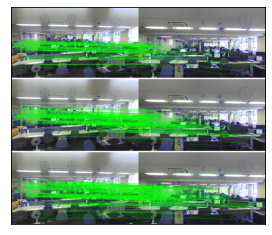

In [9]:
if FLAGS.model_type == 'pb':
    reg_model_path = os.path.join(FLAGS.reg_model, 'reg.pb')
    loc_model_path = os.path.join(FLAGS.loc_model, 'loc.pb')
    aug_model_path = os.path.join(FLAGS.loc_model, 'aug.pb')
elif FLAGS.model_type == 'ckpt':
    reg_model_path = os.path.join(FLAGS.reg_model, 'model.ckpt-550000')
    loc_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
    aug_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
else:
    raise NotImplementedError

img_paths = [FLAGS.img1_path, FLAGS.img2_path]
# load testing images.
rgb_list, gray_list = load_imgs(img_paths)
# extract regional features.
reg_feat_list = extract_regional_features(rgb_list, reg_model_path)
# extract local features and keypoint matchability.
cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list = extract_local_features(
    gray_list, loc_model_path)
# extract augmented features.
aug_feat_list = extract_augmented_features(reg_feat_list, loc_info_list, aug_model_path)
# feature matching and draw matches.
matcher = MatcherWrapper()
sift_match, sift_mask = matcher.get_matches(
    sift_feat_list[0], sift_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
    ratio=0.8 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
    err_thld=3, ransac=True, info='SIFT feautre')

base_match, base_mask = matcher.get_matches(
    loc_feat_list[0], loc_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
    ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
    err_thld=3, ransac=True, info='Raw local feature')

aug_match, aug_mask = matcher.get_matches(
    aug_feat_list[0], aug_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
    ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
    err_thld=3, ransac=True, info='Augmented local feature')

sift_disp = matcher.draw_matches(
    rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], sift_match, sift_mask)
base_disp = matcher.draw_matches(
    rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], base_match, base_mask)
aug_disp = matcher.draw_matches(
    rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], aug_match, aug_mask)

rows, cols = sift_disp.shape[0:2]
white = (np.ones((int(rows / 50), cols, 3)) * 255).astype(np.uint8)
disp = np.concatenate([sift_disp, white, base_disp, white, aug_disp], axis=0)
cv2.imwrite("rgb01.png",disp)
plt.xticks([])
plt.yticks([])
plt.imshow(disp)
plt.show()

In [9]:
cv2.imwrite("{bp}rgb01.png",disp)

True

In [28]:
def point2dTo3d(point,cam):
    z=point[2]/cam.depthScale
    x=(point[0]-cam.cx)*z/cam.fx
    y=(point[1]-cam.cy)*z/cam.fy
    return [x,y,z]

In [44]:
cams_para=[cam_zed2_21888201_left_hd1080,cam_zed2_22378008_left_hd1080,cam_zed2_22115402_left_hd1080]
# cams_para=[cam_zed2_21888201_left_hd1080,cam_zed2_21888201_left_hd1080,cam_zed2_22115402_left_hd1080]
trans12,pts_obj1,pts_obj2=get_good_matches_pts(base_match,cv_kpts_list[0],cv_kpts_list[1],imgdic,cams_para)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


pts_obj1:3990,pts_obj2:3990


In [45]:
import open3d
import copy as cp
cloud0=open3d.io.read_point_cloud(f'{bp}/pcd_mask_cam0.ply')
cloud1=open3d.io.read_point_cloud(f'{bp}/pcd_mask_cam1.ply')
# cloud0_t=cp.deepcopy(cloud1)
cloud0_gm=cloud0.transform(trans12)
ext='sift'
open3d.io.write_point_cloud(f'{bp}{ext}_pcd_trans_0_solvePnP.ply', cloud0_gm)


True

In [20]:
# !pip install -r requirements.txt

### Detect and describe local features

## Dataset Loading and Image warping

In [ ]:
# !mkdir ../dump_feats

In [ ]:
# display_image_batch((outs['canvas'] * 255).astype(np.uint8))

In [ ]:
%cd /content/lf-net-release
!python run_lfnet.py \
  --in_dir=/content/lf-net-release/samples \
  --out_dir=/content/lf-net-release/dump_feats

In [ ]:
%cd /content/lf-net-release/models
!pwd

In [ ]:
img_name = 'london_bridge-00001.jpg'
img_path = '../samples/'+img_name
kp_path = '../dump_feats/{}.npz'.format(img_name)
image = imread(img_path).astype(np.float32) / 255
kp_info = np.load(kp_path)
kpts = kp_info['kpts']
feats = kp_info['descs']
height, width = kp_info['size']
image = cv2.resize(image, (width, height))

print('Load {}-kpts, feat={}-D imsize={}x{}'.format(kpts.shape[0], feats.shape[1], width, height))

In [ ]:
def get_kpt_desc(img_name):
  # img_name = 'london_bridge-00001.jpg'
  img_path = '../samples/'+img_name
  kp_path = '../dump_feats/{}.npz'.format(img_name)
  image = imread(img_path).astype(np.float32) / 255
  kp_info = np.load(kp_path)
  kpts = kp_info['kpts']
  feats = kp_info['descs']
  height, width = kp_info['size']
  image = cv2.resize(image, (width, height))
  return kpts,feats,image


In [ ]:
def get_good_match_knn(bf,desc1,desc2):
    # マッチング器を作成する。
    matches = bf.knnMatch(desc1, desc2, k=2)
    # レシオテストを行う。
    good_matches = []
    thresh = 0.3
    for first, second in matches:
        if first.distance < second.distance * thresh:
            good_matches.append(first)
    print("good_matches:",len(good_matches))
    return good_matches
kpts1,desc1,img1= get_kpt_desc('london_bridge-00001.jpg')
kpts2,desc2,img2=get_kpt_desc('london_bridge-00002.jpg')
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
good_matches=get_good_match(bf,desc1,desc2)

In [ ]:
desc2